# Анализ данных интернет-магазина по приотиризации гипотез и А/В тестированию. 

В нашем распоряжении данные крупного интернет-магазина и список гипотез для увеличения выручки. Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**Цель исследования:**
1. Приоритизация гипотез
2. A/B-тестирование
3. Анализ результатов

**Ход исследования:**

Данные о пользователях мы получим из трех источников:

1. гипотезы: `/datasets/hypothesis.csv`

    - `Hypothesis` — краткое описание гипотезы;
    - `Reach` охват пользователей по 10-балльной шкале;
    - `Impact` влияние на пользователей по 10-балльной шкале;
    - `Confidence` уверенность в гипотезе по 10-балльной шкале; 
    - `Effort` затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
    
    
2. заказы: `/datasets/orders.csv`

    - `transactionId` — идентификатор заказа;
    - `visitorId` — идентификатор пользователя, совершившего заказ;
    - `date` — дата, когда был совершён заказ;
    - `revenue` — выручка заказа;
    - `group` — группа A/B-теста, в которую попал заказ.


3. посетители: `/datasets/visitors.csv`

    - `date` — дата;
    - `group` — группа A/B-теста;
    - `visitors` — количество посетителей в указанную дату в указанной группе A/B-теста.
    
Первым делом приступим к обзору данных, проверим качество. Далее при необходимости осуществим предобработку данных для дальнейшего корректного анализа и приступим к исследованию и анализу данных.

Исходя из этого наш проект будет состоять из четырех частей:
1. Загрузка и подготовка данных к исследованию
2. Приоритизация гипотез с помощью фреймворков `ICE` и `RICE`
3. Анализ A/B-теста:
    - Графический анализ
    - Статистический анализ
    - Принятие решений
4. Общие выводы

## Загрузка и предобработка данных к исследованию

In [1]:
# импортируем библиотеки, которые будем использовать в работе
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy import stats as st
from IPython.display import Image # библиотека для отображения картинок


In [2]:
# загрузим данные
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'), # гипотезы
        pd.read_csv('/datasets/orders.csv'), # заказы
        pd.read_csv('/datasets/visitors.csv')   # пользователи
    )  
except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'), # гипотезы
        pd.read_csv('orders.csv'), # заказы
        pd.read_csv('visitors.csv')   # пользователи
    )

### Таблица "гипотезы"

In [3]:
# объявим функцию для первичного анализа данных 
def get_info(df):
    temp_df = df.copy() 
    list_c = df.columns
    print(temp_df.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp_df[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp_df[col_l].isna().sum(),
            ', процент NaN', round(temp_df[col_l].isna().sum()/len(temp_df)*100, 2),'%')

    print('-'* 25)
    duplicates = temp_df.duplicated().sum()
    print(f'Яных дубликатов: {duplicates}')

In [4]:
pd.set_option('display.max_colwidth', None)
display(hypothesis)

# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы visits
get_info(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
-------------------------
Hypothesis ['Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'
 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'
 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов'
 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'
 'Запустить акцию, дающую скидку на товар в день рождения'
 'Запустить собственную службу доставки, что сократит срок

**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Тип данных по столбцам соответствует данным
* Все компоненты имеют оценки по 10-ти бальной шкале. Выбивающих значений нет
* Необходимо отредактировать названия столбцов

In [5]:
# приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Таблица "заказы"

In [7]:
display(orders)

# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы visits
get_info(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
-------------------------
transactionId [   1062393    4919758    7210578 ... 4281129020 4288552432 4293855558]
transactionId : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
visitorId [   5114589    6958315    8300375 ... 4279090005 4281247801 4283872382]
visitorId : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
date ['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-0

**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Необходимо изменить тип данных по столбцу `date` где хранится информация о дате когда был совершён заказ
* В данных посетители только двум группа А и В как заявлено
* Артефактов в числовых показателях нет
* Самая большая выручка по заказу составляет 1.294.500, минимальная равняется 50
* Необходимо отредактировать названия столбцов
* Необходимо проверка корректности разбиения покупателей на группы.

In [8]:
# преобразование типа данных
orders['date'] = pd.to_datetime(orders['date'])

In [9]:
# переименуем названия столбцов 
orders = orders.rename(
    columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}
)

In [10]:
# проверим на наличие покупателей, которые попали в обе группы
orders_a_gr = orders.query('group == "A"')
orders_b_gr = orders.query('group == "B"')

orders_dubl_id = orders_a_gr.merge(orders_b_gr, on='visitor_id')['visitor_id'].unique()

In [11]:
print(f'Количество покупателей, которые попали в обе группы: {len(orders_dubl_id)}')
print(f'Доля таких покупателей от общего числа: {round(len(orders_dubl_id) / len(orders["visitor_id"].unique()) * 100, 2)} %')

Количество покупателей, которые попали в обе группы: 58
Доля таких покупателей от общего числа: 5.63 %


Существует 58 покупателей, которые попали в обе тестируемые группы. Такие пересечения могут негативно повлиять на анализ теста. Доля таких пользователей 5.6 % от общего числа покупателей, поэтому считаем возможным исключить их из выборки.

In [12]:
orders = orders.query('visitor_id not in @orders_dubl_id')

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


### Таблица "посетители"

In [14]:
display(visitors)

# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы visits
get_info(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
-------------------------
date ['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']
date : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
group ['A' 'B']
group : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
visitors [361 369 378 395 406 412 413 421 468 487 490 502 507 

In [15]:
visitors['visitors'].describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Необходимо изменить тип данных по столбцу `date` где хранится информация о времени посещения интернет-магазина
* В среднем на дату посещения приходится 607 посетителей. Самый низкий показатель 361 человек, самый высокий 770 посетителей на одну дату посещения.

In [16]:
# преобразование типа данных
visitors['date'] = pd.to_datetime(visitors['date'])

In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


## Приоритизация гипотез

### Приоритизация гипотез фреймворком ICE

In [18]:
# посчитаем ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

display(hypothesis[['hypothesis' , 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективными гипотезами по **ICE** являются:

№8. Запустить акцию, дающую скидку на товар в день рождения

№0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

№7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

### Приоритизация гипотез фреймворком RICE

In [19]:
# посчитаем RICE
hypothesis['RICE'] =(
    (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
)

display(hypothesis[['hypothesis' , 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективными гипотезами по **RICE** являются:

№7. Запустить акцию, дающую скидку на товар в день рождения

№2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

№0. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

№6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

При применении RICE вместо ICE, наиболее приоритетная гипотеза № 8 (Запустить акцию, дающую скидку на товар в день рождения) по фреймворку ICE стала менее приоритетной и занимает только пятое место по приоритету. 

Это связано с тем, что скидка на товар в день рождения затронет маленькое кол-во посетителей. Компонент `Reach` по данной гипотезе имеет самый низкий уровень значимости в 1 балл. 

Соответственно исходя из формул расчета фреймворков:

$$ICE = \frac{Impact * Confidence}{Efforts}$$


$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

соответствующие изменения в приоритезации гипотез.

**В пересечении двух фреймворков приоритетными остаются гипотезы:**

№7.  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

№0.  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

№6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [20]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = (
    dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                .sort_values(by=['date','group'])
)
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = (
    dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
              .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
              .sort_values(by=['date','group'])
)
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


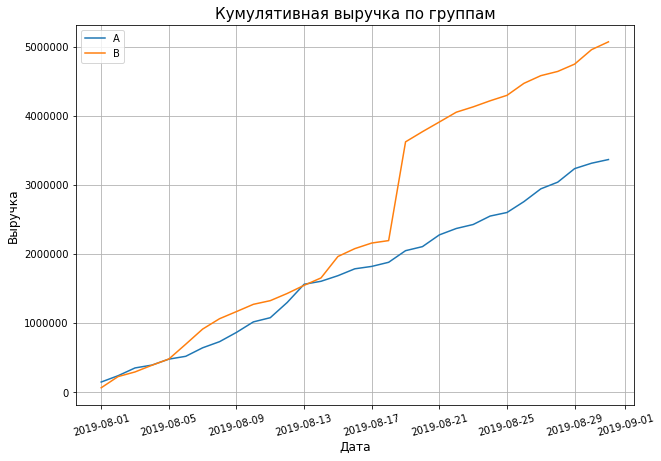

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 7))
plt.ticklabel_format(style='plain')

# строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# настроим график
plt.xticks(rotation=15)
plt.grid(True)
plt.title('Кумулятивная выручка по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.legend();

Кумулятивная выручка увеличивается в течение всего теста. Однако график выручки группы В за дату между 17 и 21 августа резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам

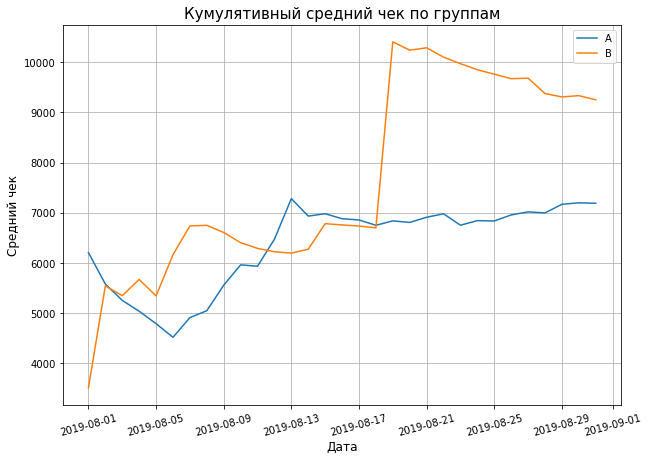

In [22]:
plt.figure(figsize=(10, 7))


# строим график среднего чека группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

# строим график среднего чека группы В
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

# настроим график
plt.xticks(rotation=15)
plt.grid(True)
plt.title('Кумулятивный средний чек по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
plt.legend();

График среднего чека растет, но мы видим резкие изменения. В группу А видимо вначале теста попали крупные заказы, но потом рост с 13 августа стабилизируется. По группе В наблюдается резкий скачек во второй половине августа. Не наблюдается равномерность среднего чека между группами нужно больше данных, чтобы прийти к реальному среднему чеку и установиться.

### График относительного изменения кумулятивного среднего чека группы B к группе A

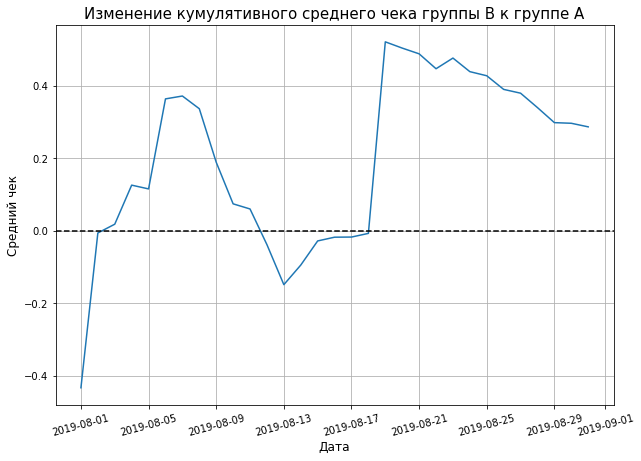

In [23]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = (
    cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

plt.figure(figsize=(10, 7))
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# настроим график
plt.xticks(rotation=15)
plt.grid(True)
plt.title('Изменение кумулятивного среднего чека группы B к группе A', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В нескольких точках график различия между сегментами резко скачет. В данных присутствуют аномальные значения выручки.

### График кумулятивного среднего количества заказов на посетителя по группам (конверсия)

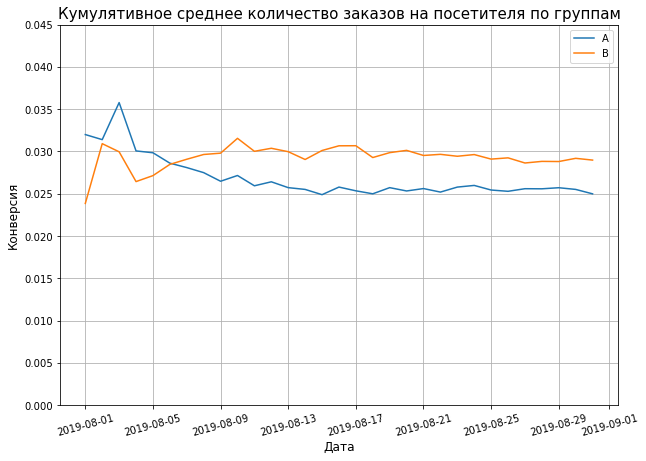

In [24]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(10, 7))
# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

# настроим график
plt.xticks(rotation=15)
plt.grid(True)
plt.title('Кумулятивное среднее количество заказов на посетителя по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.legend()
plt.ylim([0, 0.045]) ;


Кумулятивное среднее количество заказов на посетителя группы В вырвалась вперёд и зафиксировалась, а кумулятивное среднее количество заказов на посетителя группы А просела и также зафиксировалась.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A 

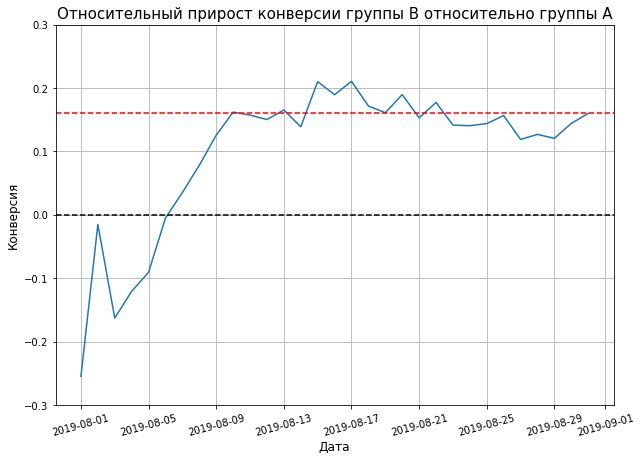

In [25]:
merged_cumulative_conversions = (
    cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

# строим график
plt.figure(figsize=(10, 7))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)


# настроим график
plt.xticks(rotation=15)
plt.grid(True)
plt.title('Относительный прирост конверсии группы B относительно группы A', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.ylim([-0.3, 0.3]) ;
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='red', linestyle='--');

In [26]:
cumulative_data_a

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837
10,2019-08-06,A,114,104,515332,3985,0.028607
12,2019-08-07,A,130,120,638580,4629,0.028084
14,2019-08-08,A,144,133,727219,5239,0.027486
16,2019-08-09,A,155,143,861456,5856,0.026469
18,2019-08-10,A,170,158,1013731,6262,0.027148


На 6 день начала теста конверсия группы В начинает превосходить конверсию группы А, и к концу теста на 16% больше. В целом судя по графикам отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.

### Точечный график количества заказов по пользователям

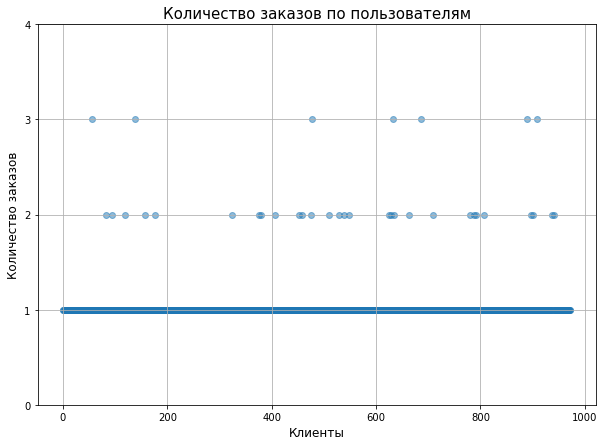

In [27]:
# сгруппируем заказы по покупателям
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']

# строим график
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(10, 7))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.grid(True)
plt.title('Количество заказов по пользователям', fontsize=15)
plt.xlabel('Клиенты', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.yticks(np.arange(0, 5, step=1));

Большинство покупателей заказывали только один раз. Однако есть покупатели, которые заказывали 2 и 4 раза. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

### 95-й и 99-й перцентили количества заказов на пользователя

In [28]:
# посчитаем выборочные перцентили количества заказов на одного пользователя
np.percentile(orders_by_users['orders'], [90, 95, 99])

array([1., 1., 2.])

Не более 5% пользователей оформляли больше, чем 1 заказ. Разумно выбрать ни больше 1 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных покупателей (покупателей кто делал заказ больше одного раза).

### Точечный график стоимостей заказов

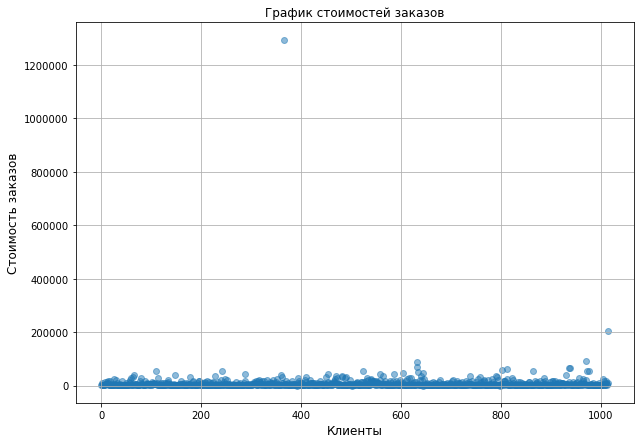

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим график
plt.figure(figsize=(10,7))
plt.ticklabel_format(style='plain')
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.grid(True)
plt.title('График стоимостей заказов')
plt.xlabel('Клиенты', fontsize=12)
plt.ylabel('Стоимость заказов', fontsize=12);

Необходим более наглядный график, так как из-за явного выброса масштаб не детальный.

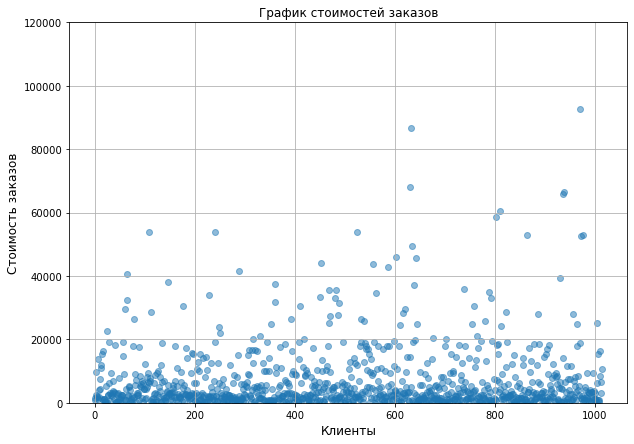

In [30]:
# строим график
plt.figure(figsize=(10,7))
plt.ticklabel_format(style='plain')
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.grid(True)
plt.title('График стоимостей заказов')
plt.xlabel('Клиенты', fontsize=12)
plt.ylabel('Стоимость заказов', fontsize=12);
plt.ylim([0, 120000]);

По данным графикам мы видим аномальные два заказа по стоимости. Один на сумму больше 1.200.000 и второй 200.000

### 95-й и 99-й перцентили стоимости заказов

In [31]:
# посчитаем выборочные перцентили стоимости заказов
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


Не более 5% заказов чек на сумму дороже 26785. 10% заказов имеют чек на сумму ни больше, чем 17990 и у 1% заказов чек более чем на сумму 53904. Выберем за верхнюю границу заказ на сумму ни более чем 27000 и отсеем аномальные значения по ней.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

* Мы оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы;
* Увидели выбросы и нашли границу для их определения.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным — без удаления аномальных посетителей используя непараметрический тест Уилкоксона-Манна-Уитни. Тест называется st.mannwhitneyu() (от англ. «U-критерий Манна-Уитни»). За критический уровень статистической значимости возьмем значение = 0.05 %.

Сформулируем гипотезы: 

- H0: Нулевая: различий в среднем количестве заказов между группами нет.
- H1: Альтернативная: различия в среднем между группами есть.

In [32]:
# начнём с подготовки данных.
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

названия столбцов данных:
- `date` — дата;
- `orders_per_date_a` — количество заказов в выбранную дату в группе A;
- `revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;
- `orders_per_date_b` — количество заказов в выбранную дату в группе B;
- `revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;
- `orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;
- `orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;
- `visitors_per_date_a` — количество пользователей в выбранную дату в группе A;
- `visitors_per_date_b` — количество пользователей в выбранную дату в группе B;
- `visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;
- `visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия среднем количестве заказов на посетителя между группами по «сырым» данным.

In [34]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(f'P-value: {stats.mannwhitneyu(sampleA, sampleB)[1]:.3}')

print(f"Относительное изменение конверсии: {sampleB.mean() / sampleA.mean() - 1:.1%}")

P-value: 0.011
Относительное изменение конверсии: 16.0%


P-value = 0.011, меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ сырых данных сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего количества заказов на посетителя в группе В к группе А равен 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверим статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным используя непараметрический тест Уилкоксона-Манна-Уитни. Тест называется st.mannwhitneyu() (от англ. «U-критерий Манна-Уитни»). За критический уровень статистической значимости возьмем значение = 0.05 %.

Сформулируем гипотезы: 

- H0: Нулевая: различий в среднем чеке между группами нет.
- H1: Альтернативная: различия в среднем чеке между группами есть

In [35]:
# передадим критерию mannwhitneyu() данные о выручке с заказов
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное изменение в среднем чеке:', '{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.829
Относительное изменение в среднем чеке: 28.7%


P-value = 0.829, что значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке заказа между группами по «сырым» данным есть различия, нет. Так же отметим, что средний чек группы B значительно выше среднего чека группы A, а именно на 29%.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

В соответствии с отмеченными аномальными значениями количества и стоимости заказов посмотрим, как изменится статистические значимости различий без них. 

In [36]:
# вычленим покупателей с аномальными значениями
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 1]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 27000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [37]:
# очистим данные от аномальных покупателей 
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Проверим статистическую значимость различий в среднем количестве заказа между группами по «очищенным» данным.

In [38]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительное изменение конверсии: ', '{0:.1%}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

P-value: 0.016
Относительное изменение конверсии:  17.4%


Как и в случае с сырыми данными, в среднем количестве заказов между группами есть статистически значимые различия. Группа В лучше по приросту среднего количества заказов на посетителя чем группа А на 17% (было 16%)

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим статистическую значимость различий по среднему чеку между группами используя очищенные данные.

In [39]:
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное изменение в среднем чеке:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.727
Относительное изменение в среднем чеке: -0.034


P-value = 0.727, что значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке заказа между группами по «очищенным» данным есть различия, нет, но стоит отметить, что средний чек группы B по сырым данным был значительно выше среднего чека группы A, а именно на 29%, тогда как после того как убрали аномальные значения средний чек значительно уменьшился и теперь ниже среднего чека группы А на 3.4%. Это огромная разница говорит о том, что в группу В записались покупатели с огромными чеками, что дал такой скачек.

### Решение по результатам теста

**Имеющиеся факты:**
- Есть статистически значимые различия по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий. Группа В лучше по приросту среднего количества заказов на посетителя чем группа А на 17% по очищенным данным (было по "сырым" 16%);


- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Средний чек группы B по сырым данным был значительно выше среднего чека группы A, а именно на 29%, тогда как после того, как убрали аномальные значения средний чек значительно уменьшился и теперь ниже среднего чека группы А на 3.4%;


- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

<img src="https://habrastorage.org/webt/ub/ol/cg/ubolcgxzhghlkkefcv2wr71cd58.png" width="500" height="500" />

- График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

<img src="https://habrastorage.org/webt/8f/e5/ss/8fe5ssn3r3imq2m_dwk6shvfmaa.png" width="500" height="500" />

- **Исходя из обнаруженных фактов, тест следует остановить и признать успешным. Продолжать смысла нет так, как группа В лучше группы А только по конверсии. По приросту среднего чека группы примерно равны.**